# Финальный проект МАДМО-5

В данной статье, представляемой в качестве отчёта по финальному проекту курса "Методы анализ данных и машинного обучения", рассматривается задача краткосрочного (24-48 часов) прогнозирования энергопотребления офисного здания для возможности управления системой накопления электроэнергии (СНЭ) для снижения затрат на электроэнергию в среднесрочной перспективе.

Данная работа организована следующим образом: в разделе "Введение" мы обсудим общую постановку задачи и актуальность частного вопроса, которому посвящена данная статья. В разделе "Данные" будут загружены данные для обучения и проверки качества моделей и проведено их исследование, очистка и подготовка. Раздел "Классические алгоритмы (ARIMA)" посвящён построению предсказательной модели на основе алгоритма интегрированной модели авторегрессии -- скользящего среднего.
В разделе "Алгоритмы на основе нейросетей (LSTM)" будут исследованы возможности прогнозирования интересующих нас временных рядов моделями на основе длинных цепей элементов краткосрочной памяти. Выводы относительно полученных результатов и их применимости на практике помещены в раздел "Заключение".

# Введение

Общая постановка задачи оптимизации энергопотребления с помощью накопителя состоит в управлении СНЭ (выдаче команд на потребление или выдачу мощности в сеть) с целью уменьшения ежемесячной платы за электроэнергию. Основная идея экономической оптимальности состоит в уменьшении потребления электроэнергии из внешней сети за счёт использования энергии, запасённой в СНЭ, тогда, когда это максимально невыгодно (в зависимости от ценовой категории и конкретного тарифа, это может происходить в разное время и в разных режимах), и зарядка накопителя в период минимальной стоимости электроэнергии.

Тарифы на электроэнергию в России задаются на сетке с шагом в один час, поэтому имеет смысл работать с именно таким временным разрешением. Кроме того тарифы можно рассматривать как периодическин временные ряды с периодом в одни сутки, что даёт нам другой временной интервал для работы.

Во всех сценариях снижения энергопотребления за счёт использования СНЭ возникает задача прогнозирования потребления электроэнергии на горизонте порядка двух суток, причём точность прогноза на ближайшие часы более важна, нежели точность прогноза на вторые сутки.


# Данные

Здесь была ячейка с подучением данных с гуглодиска

In [2]:
!pip install pytorch_lightning
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00


Импорты и предварительная подготовка среды исполнения

In [3]:
import codecs
import csv
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import platform
import pytorch_lightning as pl
import random
import shutil
import statsmodels.api as sm
import time
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

from pmdarima.arima import auto_arima
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torchsummary import summary
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torchvision.transforms import v2
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
from types import SimpleNamespace
from xgboost import plot_importance, plot_tree

%matplotlib inline

%load_ext tensorboard

print(platform.system())
if platform.system() == 'Windows':
    CHECKPOINT_PATH = "d:/saved_models/ConvNets"
else:
    CHECKPOINT_PATH = "saved_models/ConvNets"

os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.environ['CHECKPOINT_PATH'] = CHECKPOINT_PATH

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

Linux


device(type='cpu')

Посмотрим на данные глазами:

In [4]:
df = pd.read_excel('data/building_data.xlsx')
print(df.columns.tolist())
df

['time', '_Accumulator_Bus_1_e_TM1H_mv_val', '_Accumulator_Bus_1_e_TM1H_mv_qual', '_Accumulator_Bus_1_p_TM1H_mv_qual', '_Accumulator_Bus_1_p_TM1H_mv_val', '_Accumulator_Bus_1_phaseA_p_TM1H_mv_val', '_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual', '_Accumulator_Bus_1_phaseB_p_TM1H_mv_val', '_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual', '_Accumulator_Bus_1_phaseC_p_TM1H_mv_val', '_Accumulator_Bus_1_phaseC_p_TM1H_mv_qual', '_Accumulator_Bus_2_e_TM1H_mv_val', '_Accumulator_Bus_2_e_TM1H_mv_qual', '_Accumulator_Bus_2_p_TM1H_mv_qual', '_Accumulator_Bus_2_p_TM1H_mv_val', '_Accumulator_Bus_2_phaseA_p_TM1H_mv_val', '_Accumulator_Bus_2_phaseA_p_TM1H_mv_qual', '_Accumulator_Bus_2_phaseB_p_TM1H_mv_val', '_Accumulator_Bus_2_phaseB_p_TM1H_mv_qual', '_Accumulator_Bus_2_phaseC_p_TM1H_mv_val', '_Accumulator_Bus_2_phaseC_p_TM1H_mv_qual', '_Accumulator_Bus_3_e_TM1H_mv_val', '_Accumulator_Bus_3_e_TM1H_mv_qual', '_Accumulator_Bus_3_p_TM1H_mv_qual', '_Accumulator_Bus_3_p_TM1H_mv_val', '_Accumulator_Bus_3_phaseA_p_TM

,time,_Accumulator_Bus_1_e_TM1H_mv_val,_Accumulator_Bus_1_e_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_qual,_Accumulator_Bus_1_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_val,_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseB_p_TM1H_mv_val,_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual,_Accumulator_Bus_1_phaseC_p_TM1H_mv_val,...,_unctrl_load_Bus_3_phaseC_p_TM1H_mv_val,_unctrl_load_Bus_3_phaseC_p_TM1H_mv_qual,_unctrl_load_Bus_4_p_TM1H_mv_val,_unctrl_load_Bus_4_p_TM1H_mv_qual,_unctrl_load_Bus_4_phaseA_p_TM1H_mv_val,_unctrl_load_Bus_4_phaseA_p_TM1H_mv_qual,_unctrl_load_Bus_4_phaseB_p_TM1H_mv_val,_unctrl_load_Bus_4_phaseB_p_TM1H_mv_qual,_unctrl_load_Bus_4_phaseC_p_TM1H_mv_val,_unctrl_load_Bus_4_phaseC_p_TM1H_mv_qual
0,2018-03-16 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-16 14:00:00,NaN,NaN,GOOD MEAN,-0.004168,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-03-16 15:00:00,NaN,NaN,GOOD MEAN,0.001829,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-03-16 16:00:00,NaN,NaN,GOOD MEAN,0.002485,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-03-16 17:00:00,NaN,NaN,GOOD MEAN,-0.001558,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21177,2020-10-22 08:00:00,18.8,GOOD DERIVED,GOOD MEAN,-0.542340,-0.180542,GOOD MEAN,-0.177375,GOOD MEAN,-0.178500,...,20.758814,GOOD MEAN,21.071439,GOOD MEAN,8.650802,GOOD MEAN,6.928741,GOOD MEAN,5.491897,GOOD MEAN
21178,2020-10-22 09:00:00,18.6,GOOD DERIVED,GOOD MEAN,-0.000457,0.000000,GOOD MEAN,0.000000,GOOD MEAN,0.000000,...,18.140487,GOOD MEAN,22.291108,GOOD MEAN,9.613387,GOOD MEAN,6.840255,GOOD MEAN,5.837466,GOOD MEAN
21179,2020-10-22 10:00:00,18.6,GOOD DERIVED,GOOD MEAN,0.001608,0.000000,GOOD MEAN,-0.000056,GOOD MEAN,0.000000,...,18.917276,GOOD MEAN,21.170831,GOOD MEAN,9.101928,GOOD MEAN,6.422705,GOOD MEAN,5.646199,GOOD MEAN
21180,2020-10-22 11:00:00,18.4,GOOD DERIVED,GOOD MEAN,-0.003768,0.000000,GOOD MEAN,0.000000,GOOD MEAN,0.000000,...,18.658877,GOOD MEAN,22.495367,GOOD MEAN,9.331728,GOOD MEAN,6.934822,GOOD MEAN,6.228817,GOOD MEAN


Как мы видим, часть значений отсутствует, в данных имеются пропуски, что, к сожалению, не является редкостью в реальных приложениях

Пара слов про датасет: он представляет собой данные по энергопотреблению, собранные за несколько лет в офисном здании.

Помимо численных значений измеряемых величин, в данном наборе присутствуют атрибуты качества данных(в колонках, заканчивающихся на "qual"), но в общем случае таковых может и не оказаться.

Нас интересует общее потребление, представляется, что его возможно предсказать с большей точностью.

In [5]:
df.set_index('time', inplace=True)
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21182 entries, 2018-03-16 13:00:00 to 2020-10-22 12:00:00
Data columns (total 152 columns):
 #    Column                                     Non-Null Count  Dtype  
---   ------                                     --------------  -----  
 0    _Accumulator_Bus_1_e_TM1H_mv_val           10800 non-null  float64
 1    _Accumulator_Bus_1_e_TM1H_mv_qual          10800 non-null  object 
 2    _Accumulator_Bus_1_p_TM1H_mv_qual          21143 non-null  object 
 3    _Accumulator_Bus_1_p_TM1H_mv_val           21143 non-null  float64
 4    _Accumulator_Bus_1_phaseA_p_TM1H_mv_val    10800 non-null  float64
 5    _Accumulator_Bus_1_phaseA_p_TM1H_mv_qual   10800 non-null  object 
 6    _Accumulator_Bus_1_phaseB_p_TM1H_mv_val    10800 non-null  float64
 7    _Accumulator_Bus_1_phaseB_p_TM1H_mv_qual   10800 non-null  object 
 8    _Accumulator_Bus_1_phaseC_p_TM1H_mv_val    10800 non-null  float64
 9    _Accumulator_Bus_1_phaseC_p_TM1H_mv_qual   108

Удалим лишние колонки из набора данных.

In [6]:
print([col for col in df.columns if col.endswith('_qual')])
df = df.drop([col for col in df.columns if col.endswith('_qual')], axis=1)
df = df.drop([col for col in df.columns if 'phase' in col], axis=1)
df = df.drop([col for col in df.columns if 'onoff' in col], axis=1)
df = df.drop([col for col in df.columns if '_e_' in col], axis=1)
df = df.drop([col for col in df.columns if '_unctrl_load' in col], axis=1)
df = df.drop([col for col in df.columns if '_roof' in col], axis=1)
df = df.drop([col for col in df.columns if '_Accumulator' in col], axis=1)
df = df.drop(['_All_Consumers_p_TM1H_mv_val'], axis=1)
df.info(max_cols=200)

['_Accumulator_Bus_1_e_TM1H_mv_qual', '_Accumulator_Bus_1_p_TM1H_mv_qual', '_Accumulator_Bus_1_phaseA_p_TM1H_mv_qual', '_Accumulator_Bus_1_phaseB_p_TM1H_mv_qual', '_Accumulator_Bus_1_phaseC_p_TM1H_mv_qual', '_Accumulator_Bus_2_e_TM1H_mv_qual', '_Accumulator_Bus_2_p_TM1H_mv_qual', '_Accumulator_Bus_2_phaseA_p_TM1H_mv_qual', '_Accumulator_Bus_2_phaseB_p_TM1H_mv_qual', '_Accumulator_Bus_2_phaseC_p_TM1H_mv_qual', '_Accumulator_Bus_3_e_TM1H_mv_qual', '_Accumulator_Bus_3_p_TM1H_mv_qual', '_Accumulator_Bus_3_phaseA_p_TM1H_mv_qual', '_Accumulator_Bus_3_phaseB_p_TM1H_mv_qual', '_Accumulator_Bus_3_phaseC_p_TM1H_mv_qual', '_Accumulator_Bus_4_e_TM1H_mv_qual', '_Accumulator_Bus_4_p_TM1H_mv_qual', '_Accumulator_Bus_4_phaseA_p_TM1H_mv_qual', '_Accumulator_Bus_4_phaseB_p_TM1H_mv_qual', '_Accumulator_Bus_4_phaseC_p_TM1H_mv_qual', '_All_Consumers_p_TM1H_mv_qual', '_Bus_1_p_TM1H_mv_qual', '_Bus_2_p_TM1H_mv_qual', '_Bus_3_p_TM1H_mv_qual', '_Bus_4_p_TM1H_mv_qual', '_Consumers_Bus_1_p_TM1H_mv_qual', '_Consu

Для правильной работы алгоритмов, заполним пропуски в данных. Как мы помним, в некоторых времянных рядах отсутствуют первые значения, поэтому после заполнения методом экстраполяции последнего значения(ffill), заполним начальные значения таких рядов обратной экстраполяцией (bfill).

In [7]:
df = df.asfreq('h')
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
print(df.info(max_cols=200))
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22824 entries, 2018-03-16 13:00:00 to 2020-10-22 12:00:00
Freq: H
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _Bus_1_p_TM1H_mv_val               22824 non-null  float64
 1   _Bus_2_p_TM1H_mv_val               22824 non-null  float64
 2   _Bus_3_p_TM1H_mv_val               22824 non-null  float64
 3   _Bus_4_p_TM1H_mv_val               22824 non-null  float64
 4   _Consumers_Bus_1_p_TM1H_mv_val     22824 non-null  float64
 5   _Consumers_Bus_2_p_TM1H_mv_val     22824 non-null  float64
 6   _Consumers_Bus_3_p_TM1H_mv_val     22824 non-null  float64
 7   _Consumers_Bus_4_p_TM1H_mv_val     22824 non-null  float64
 8   _externalGrid_Bus_1_p_TM1H_mv_val  22824 non-null  float64
 9   _externalGrid_Bus_2_p_TM1H_mv_val  22824 non-null  float64
 10  _externalGrid_Bus_3_p_TM1H_mv_val  22824 non-null  float64
 11  _externalGr

,_Bus_1_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_val,_Consumers_Bus_1_p_TM1H_mv_val,_Consumers_Bus_2_p_TM1H_mv_val,_Consumers_Bus_3_p_TM1H_mv_val,_Consumers_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_1_p_TM1H_mv_val,_externalGrid_Bus_2_p_TM1H_mv_val,_externalGrid_Bus_3_p_TM1H_mv_val,_externalGrid_Bus_4_p_TM1H_mv_val
time,,,,,,,,,,,,
2018-03-16 13:00:00,32.176472,35.021871,24.439199,23.505104,31.688145,36.389503,42.981443,23.918451,38.284179,35.074638,25.183670,37.931355
2018-03-16 14:00:00,32.176472,33.457265,24.439199,23.505104,31.688145,36.389503,42.981443,23.918451,38.191219,33.457265,24.439199,39.505127
2018-03-16 15:00:00,32.176472,23.242523,22.388807,20.283791,31.688145,36.389503,42.981443,23.918451,38.191219,23.174190,22.389029,35.920340
2018-03-16 16:00:00,13.661334,15.868997,20.720294,18.140407,31.688145,36.389503,42.981443,23.918451,19.706542,15.868997,20.720294,33.977176
2018-03-16 17:00:00,11.391349,16.007367,20.323191,15.592572,31.688145,36.389503,42.981443,23.918451,17.455634,16.008700,20.323191,31.580900
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-22 08:00:00,35.019464,28.282467,56.547923,21.071439,35.019464,28.282467,56.547923,21.071439,35.555964,28.282422,57.055617,21.071344
2020-10-22 09:00:00,34.514320,28.739764,48.609889,22.291108,34.514320,28.739764,48.609889,22.291108,34.514309,28.739759,48.609663,22.291085
2020-10-22 10:00:00,33.802843,28.712950,52.332326,21.170831,33.802843,28.712950,52.332326,21.170831,33.802827,28.712938,52.332771,21.171005


In [8]:
df.describe()

,_Bus_1_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_val,_Consumers_Bus_1_p_TM1H_mv_val,_Consumers_Bus_2_p_TM1H_mv_val,_Consumers_Bus_3_p_TM1H_mv_val,_Consumers_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_1_p_TM1H_mv_val,_externalGrid_Bus_2_p_TM1H_mv_val,_externalGrid_Bus_3_p_TM1H_mv_val,_externalGrid_Bus_4_p_TM1H_mv_val
count,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000
mean,18.748299,19.327687,25.091074,13.821642,11.506579,19.377826,18.477016,13.855665,19.712447,19.484713,25.190034,15.804985
std,11.910132,10.879116,10.105732,6.940433,1101.611180,10.897992,1006.855500,6.954217,12.023525,10.887760,10.307177,8.800844
min,0.000000,0.000000,0.000000,0.000000,-166398.648447,0.000000,-152079.016030,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.026818,11.683319,19.850695,8.914391,10.051042,11.692857,19.873445,8.925211,10.506210,11.710971,19.818966,9.257436
50%,12.994100,13.129996,22.034590,10.639726,13.020335,13.145631,22.054361,10.659877,13.976311,13.250125,22.080570,11.659790
75%,28.609642,28.157055,27.448111,19.253047,28.923748,28.425013,27.474720,19.383777,29.191510,27.604572,27.930514,22.063310
max,62.408107,61.997504,59.547365,51.389073,62.408107,61.997504,59.547365,51.389073,72.080613,64.664036,68.851662,51.389073


Минимальные значения некоторых временных рядов -- -166398.648447, очевидно, нефизические. Заменим их на 0.

In [9]:
df.loc[df['_Consumers_Bus_1_p_TM1H_mv_val'] < 0 ] = 0.0
df.loc[df['_Consumers_Bus_3_p_TM1H_mv_val'] < 0 ] = 0.0
df.describe()

,_Bus_1_p_TM1H_mv_val,_Bus_2_p_TM1H_mv_val,_Bus_3_p_TM1H_mv_val,_Bus_4_p_TM1H_mv_val,_Consumers_Bus_1_p_TM1H_mv_val,_Consumers_Bus_2_p_TM1H_mv_val,_Consumers_Bus_3_p_TM1H_mv_val,_Consumers_Bus_4_p_TM1H_mv_val,_externalGrid_Bus_1_p_TM1H_mv_val,_externalGrid_Bus_2_p_TM1H_mv_val,_externalGrid_Bus_3_p_TM1H_mv_val,_externalGrid_Bus_4_p_TM1H_mv_val
count,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000,22824.000000
mean,18.746941,19.326048,25.089759,13.820571,18.797091,19.376187,25.140135,13.854595,19.710439,19.482736,25.188119,15.803154
std,11.910502,10.879210,10.107044,6.940680,11.905331,10.898094,10.122221,6.954469,12.022990,10.887202,10.307797,8.799786
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.026180,11.683182,19.850092,8.913773,10.051042,11.692805,19.873445,8.925052,10.505553,11.710880,19.818734,9.257193
50%,12.994007,13.129996,22.034428,10.639351,13.020335,13.145431,22.054361,10.659773,13.974957,13.249271,22.080210,11.659465
75%,28.605014,28.151446,27.446120,19.247558,28.923748,28.425013,27.474720,19.382903,29.186408,27.600672,27.927851,22.062617
max,62.408107,61.997504,59.547365,51.389073,62.408107,61.997504,59.547365,51.389073,72.080613,64.664036,68.851662,51.389073


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

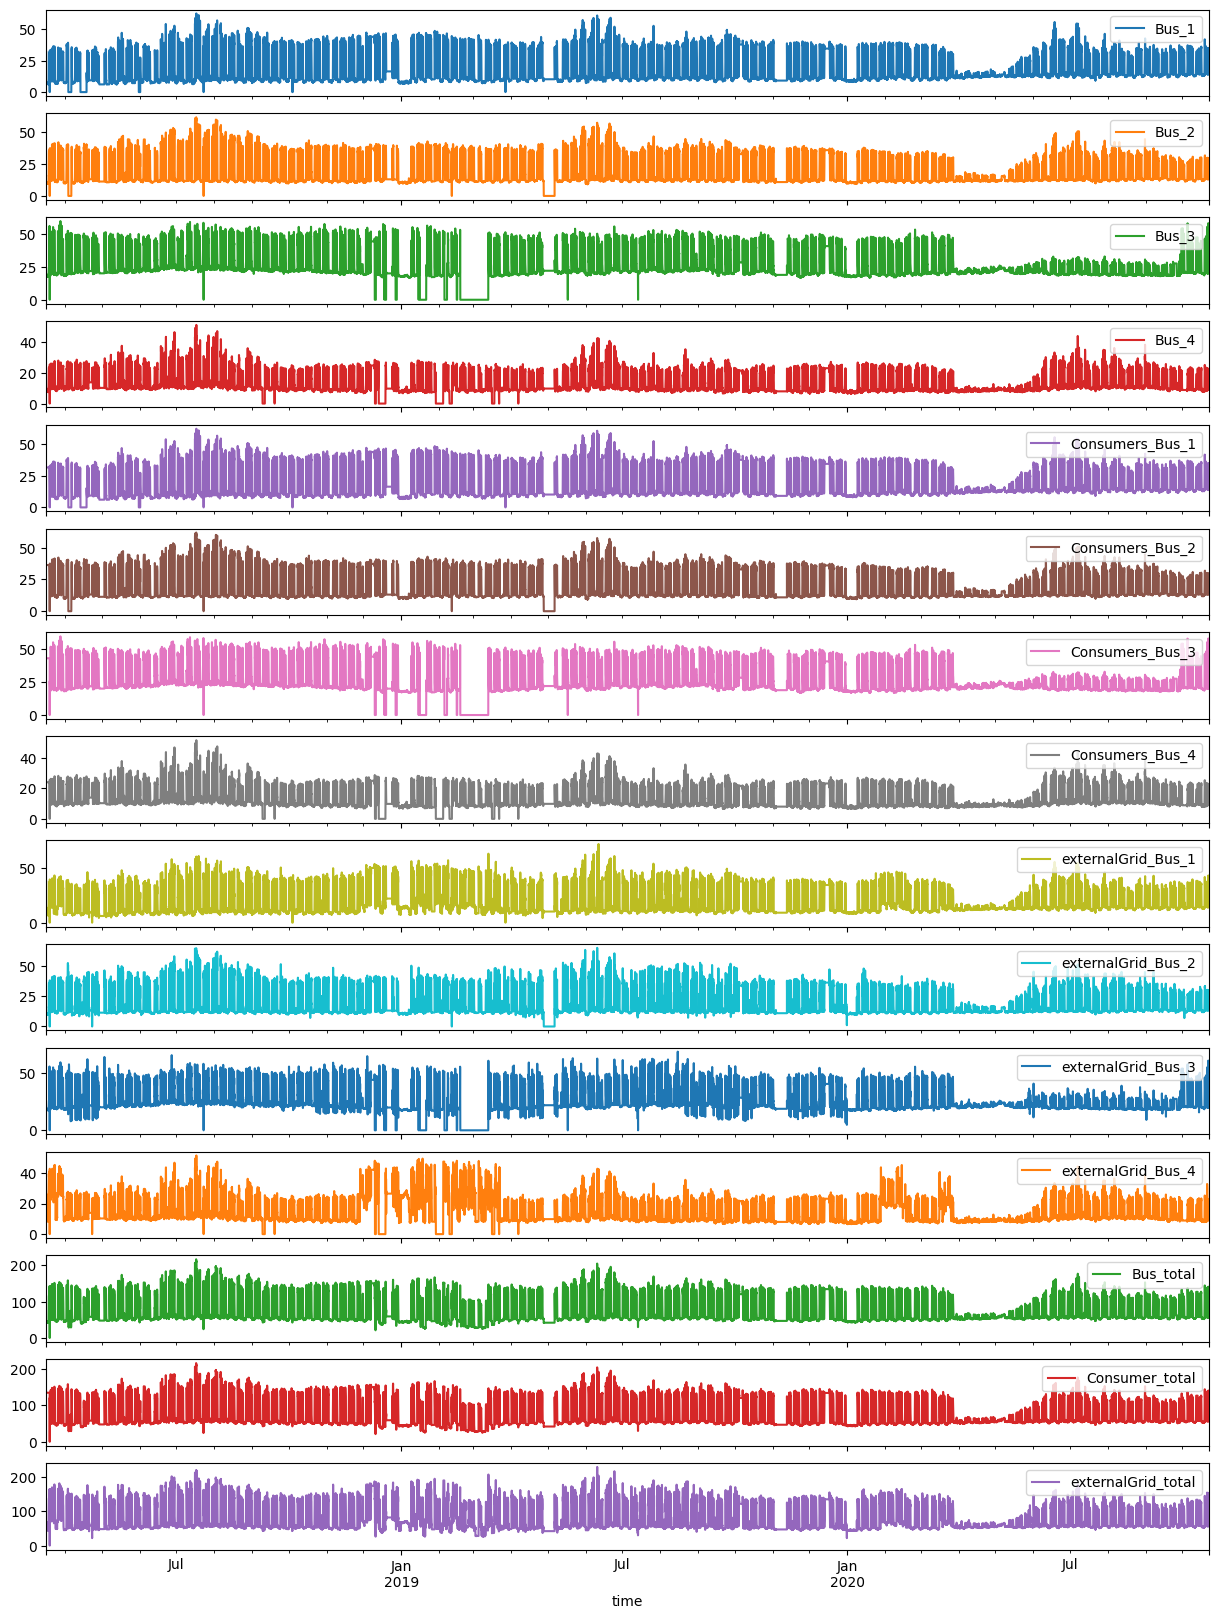

In [10]:
def rename(old_name: str) -> str:
    return old_name[1:-len('_p_TM1H_mv_val')]

df_plottable = df.rename(columns={old_name: rename(old_name) for old_name in df.columns.values if not old_name.startswith('diff')})
df_plottable['Bus_total'] = (df_plottable['Bus_1'] + df_plottable['Bus_2']
                             + df_plottable['Bus_3'] + df_plottable['Bus_4'])
df_plottable['Consumer_total'] = (df_plottable['Consumers_Bus_1'] +
                                  df_plottable['Consumers_Bus_2'] +
                                  df_plottable['Consumers_Bus_3'] +
                                  df_plottable['Consumers_Bus_4'])

df_plottable['externalGrid_total'] = (df_plottable['externalGrid_Bus_1'] +
                                      df_plottable['externalGrid_Bus_2'] +
                                      df_plottable['externalGrid_Bus_3'] +
                                      df_plottable['externalGrid_Bus_4'])

df_plottable.plot(subplots=True, figsize = (15, 20))

Отметим следующие характерные особенности зависимости потребления электроэнергии от времени:

*   Ярко выраженная периодичность(7 дней), связанная с рабочим циклом.
*   Провалы в районе долгих выходных в начале января и в начале мая
*   Уменьшение потребления на два месяца в конце марта 2020-го года, очевидно, связанная с пандемией COVID-19
*   В дальнейшем, потребление электроэнгергии офисным зданием восстановилось примерно до 80% от уровня предыдущего года



In [11]:
df = df_plottable
col = 'Consumer_total'
df

,Bus_1,Bus_2,Bus_3,Bus_4,Consumers_Bus_1,Consumers_Bus_2,Consumers_Bus_3,Consumers_Bus_4,externalGrid_Bus_1,externalGrid_Bus_2,externalGrid_Bus_3,externalGrid_Bus_4,Bus_total,Consumer_total,externalGrid_total
time,,,,,,,,,,,,,,,
2018-03-16 13:00:00,32.176472,35.021871,24.439199,23.505104,31.688145,36.389503,42.981443,23.918451,38.284179,35.074638,25.183670,37.931355,115.142646,134.977542,136.473842
2018-03-16 14:00:00,32.176472,33.457265,24.439199,23.505104,31.688145,36.389503,42.981443,23.918451,38.191219,33.457265,24.439199,39.505127,113.578040,134.977542,135.592811
2018-03-16 15:00:00,32.176472,23.242523,22.388807,20.283791,31.688145,36.389503,42.981443,23.918451,38.191219,23.174190,22.389029,35.920340,98.091593,134.977542,119.674778
2018-03-16 16:00:00,13.661334,15.868997,20.720294,18.140407,31.688145,36.389503,42.981443,23.918451,19.706542,15.868997,20.720294,33.977176,68.391032,134.977542,90.273008
2018-03-16 17:00:00,11.391349,16.007367,20.323191,15.592572,31.688145,36.389503,42.981443,23.918451,17.455634,16.008700,20.323191,31.580900,63.314478,134.977542,85.368426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-22 08:00:00,35.019464,28.282467,56.547923,21.071439,35.019464,28.282467,56.547923,21.071439,35.555964,28.282422,57.055617,21.071344,140.921294,140.921294,141.965348
2020-10-22 09:00:00,34.514320,28.739764,48.609889,22.291108,34.514320,28.739764,48.609889,22.291108,34.514309,28.739759,48.609663,22.291085,134.155082,134.155082,134.154816
2020-10-22 10:00:00,33.802843,28.712950,52.332326,21.170831,33.802843,28.712950,52.332326,21.170831,33.802827,28.712938,52.332771,21.171005,136.018950,136.018950,136.019541


In [12]:
df['diff_'+col] = df[col].diff()

print(df[col].describe())
print(df['diff_'+col].describe())

count    22824.000000
mean        77.168007
std         36.038767
min          0.000000
25%         51.472059
50%         57.881171
75%        107.302888
max        216.391966
Name: Consumer_total, dtype: float64
count    22823.000000
mean        -0.000332
std          9.622984
min       -134.977542
25%         -2.054802
50%         -0.128065
75%          0.746666
max        125.840358
Name: diff_Consumer_total, dtype: float64


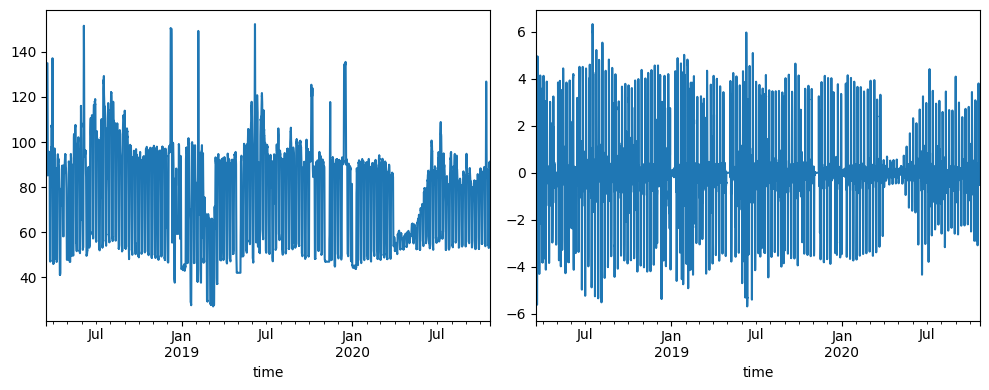

In [13]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
df[col].rolling(24).mean().plot(ax=ax1)
ax2 = plt.subplot(122)

df['diff_'+col].rolling(24).mean().plot(ax=ax2)
plt.tight_layout()
plt.show()


Построим графики автокорреляции и частичной автокорреляции

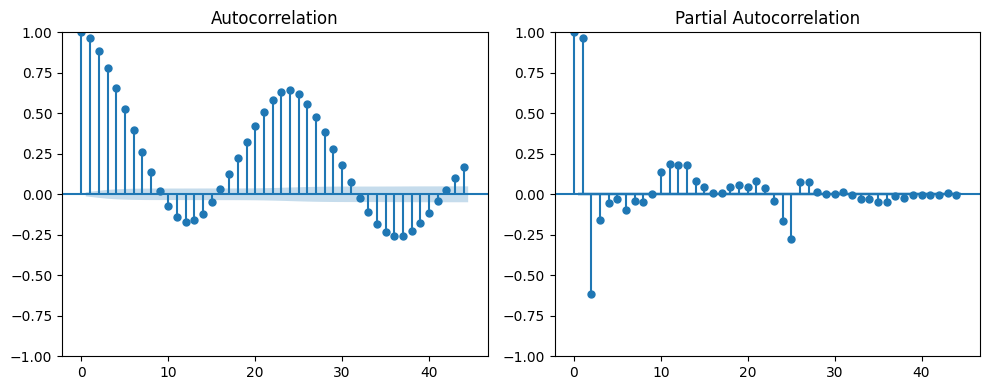

In [14]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(df[col], ax=ax1)

ax2 = plt.subplot(122)
plot_pacf(df[col], ax=ax2)

plt.tight_layout()
plt.show()


Убедимся в стационарности временных рядов:

In [15]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

for col_name in ['Bus_total', 'Consumer_total', 'externalGrid_total']:
    print(col_name)
    check_stationarity(df[col_name])

Bus_total
ADF Statistic: -18.585831
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
Consumer_total
ADF Statistic: -18.548636
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
externalGrid_total
ADF Statistic: -17.795504
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


Посмотрим на сезонную декомпозицию характерного участка временных рядов. В дальнейшем, будем использовать данный участок для иллюстрации работы алгоритмов.

In [16]:
data_size = 15000

<Figure size 640x480 with 0 Axes>

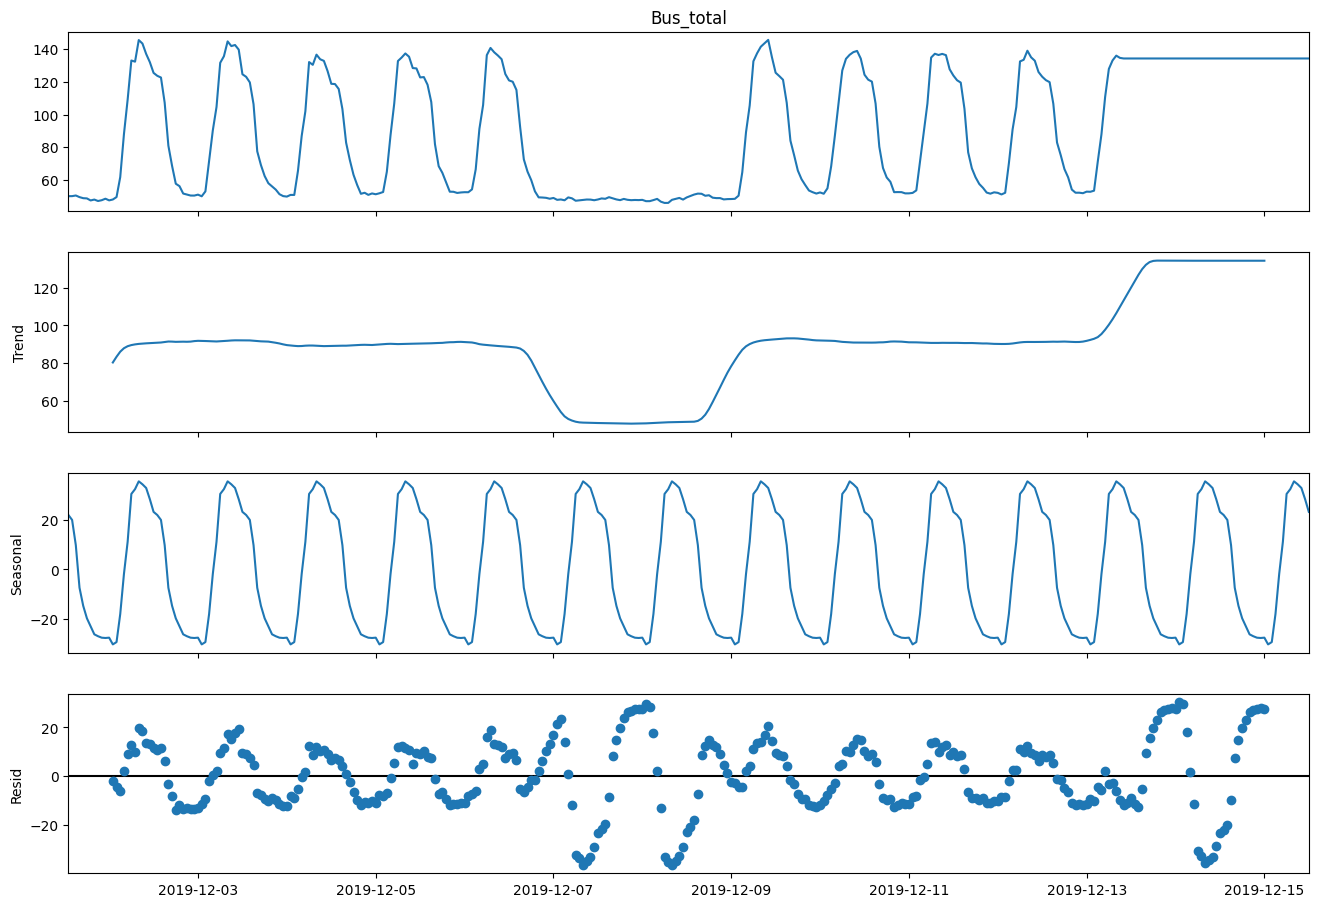

<Figure size 640x480 with 0 Axes>

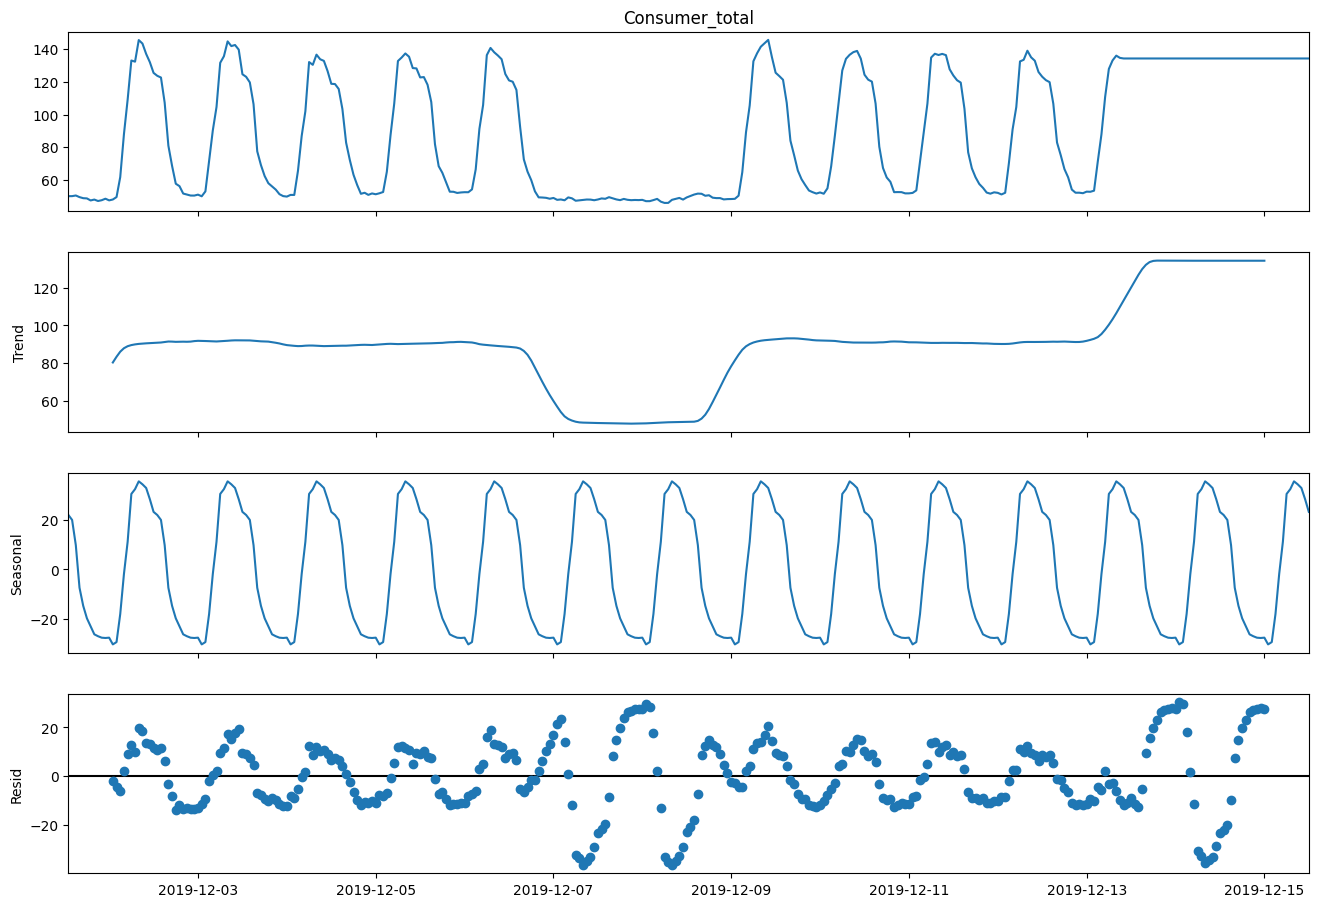

<Figure size 640x480 with 0 Axes>

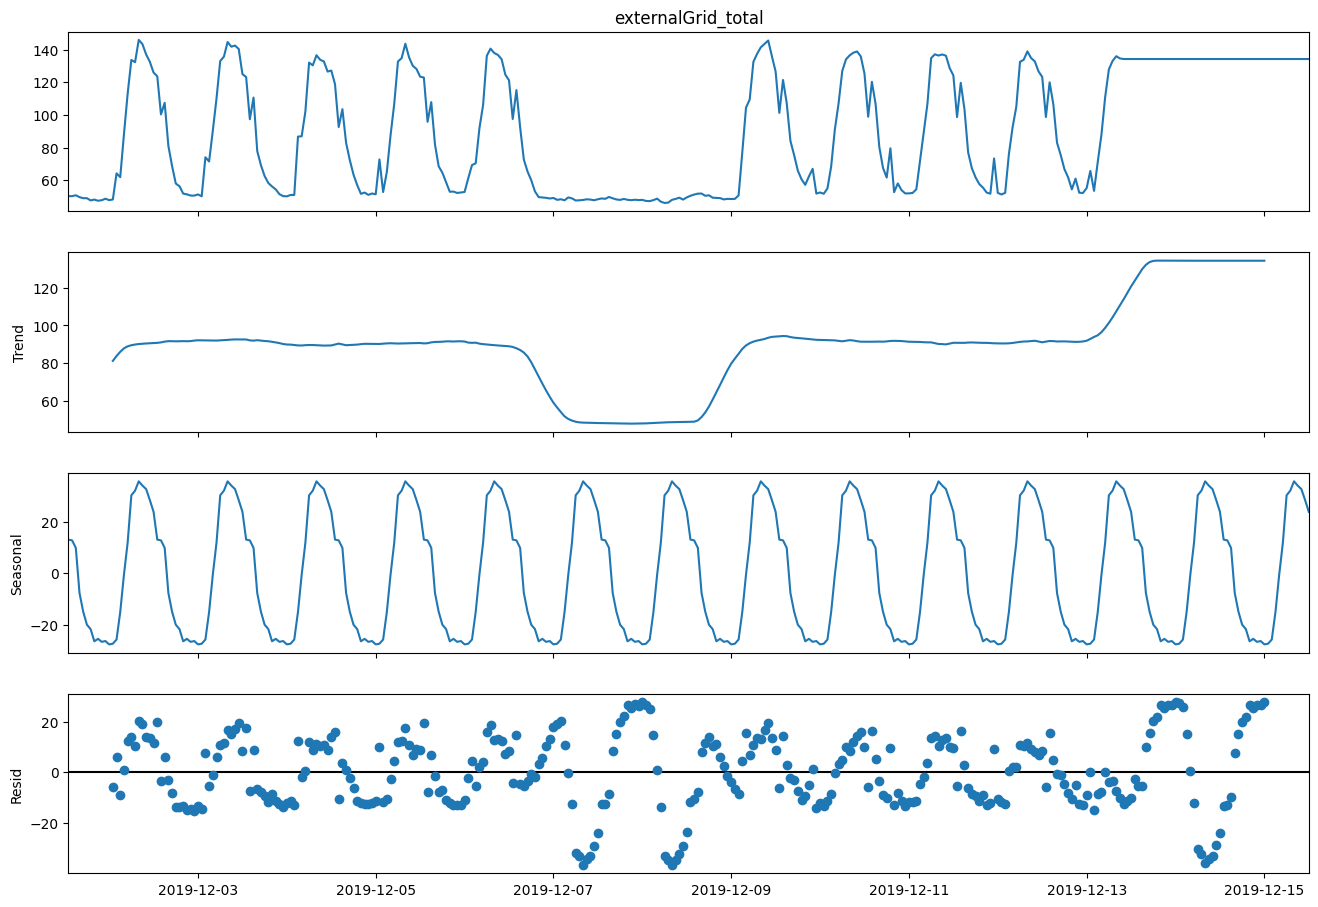

In [17]:
for col_name in ['Bus_total', 'Consumer_total', 'externalGrid_total']:
    result = seasonal_decompose(
        df[col_name][data_size: data_size + 24*14],
        model='additive',
        )
    fig = plt.figure()
    fig = result.plot()
    fig.set_size_inches(15, 10)

# Классические алгоритмы (ARIMA)




Начнём рассмотрение алгоритмов предсказания временных рядов с классической модели интегрированной авторегрессии — скользящего среднего (ARIMA) в её современной инкарнации -- SARIMAX. У данной модели имеются гиперпараметры, влияющие на точность прогнозирования, мы будем подбирать их при помощи библиотеки pmdarima [1].

Один из самых важных вопросов обучения модели --- это выбор набора данных для него. Эмпирическое правило "чем больше, тем лучше", однако, плохо применимо в нашем случае:

Во-первых, в большинстве проектов нет возможности собрать данные больше чем за два-три месяца до запуска.

Во-вторых, общая задача оптимального управления СНЭ, как правило, решается на промышленных компьютерах с ограниченными объёмами памяти и ресурсами процессора, поэтому минимизация вычислительной сложности и потребления памяти моделью --- важная задача в разработке алгоритма предсказания. Чем меньше данных мы используем для обучения, тем меньше вычислительная сложность всего процесса.

В третьих, время обучения также уменьшается с уменьшением объёма датасета, что также удобно для данной задачи.

Исходя из указанных соображений, объём набора данных для обучения выбран примерно равным 3-м месяцам (90 дней). Не последнюю роль в данном выборе сыграл тот экспериментальный факт, что больший размер обучающей выборки приводит к переполнению памяти в стандартной колабовской витруалке и её перезагрузке.

In [18]:
data_size = 2300
train_set_size = 24*30*3

In [19]:

check_data = df[col].values.astype('float16')[data_size - train_set_size : data_size]
stepwise_fit = auto_arima(check_data,
                          start_p=1,
                          start_q=1,
                          max_p=3,
                          max_q=3,
                          m=24,
                          start_P=0,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True,
                          n_jobs=4)
gc.collect()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=15037.564, Time=10.92 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=21668.013, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=15202.475, Time=7.40 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=18513.009, Time=9.46 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=25368.365, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=15321.534, Time=1.00 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=32.01 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=14974.308, Time=34.00 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=83.47 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=18479.151, Time=35.18 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=15293.521, Time=28.34 sec
 ARIMA(2,0,1)(0,0,2)[24] intercept   : AIC=14639.681, Time=44.97 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=14675.540, Time=11.54 sec
 ARIMA(2,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=107.68 sec
 ARIMA(2,0,1)

35433

In [20]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2160
Model:             SARIMAX(3, 0, 2)x(0, 0, 2, 24)   Log Likelihood               -7309.887
Date:                            Mon, 22 Jan 2024   AIC                          14637.774
Time:                                    17:02:42   BIC                          14688.875
Sample:                                         0   HQIC                         14656.464
                                           - 2160                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.1737      0.815      7.571      0.000       4.576       7.772
ar.L1          0.8245      0.058     14.112      0.000       0.710       0.939
ar.L2          0.8686      0.081     10.751      0.000       0.710       1.027
ar.L3         -0.7722      0.040    -19.527      0.000      -0.850      -0.695
ma.L1          0.4925      0.060      8.205      0.000       0.375       0.610
ma.L2         -0.4567      0.032    -14.125      0.000      -0.520      -0.393
ma.S.L24       0.3031      0.015     20.799      0.000       0.275       0.332
ma.S.L48       0.1146      0.020      5.834      0.000       0.076       0.153
sigma2        50.8024      0.590     86.111      0.000      49.646      51.959
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):            122264.39
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             3.01
Prob(H) (two-sided):                  0.39   Kurtosis:                        39.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
predictions = stepwise_fit.predict(n_periods=72)
test_data = df[col][data_size: data_size + len(predictions)]

mae = np.mean(np.abs(predictions - test_data))
mse = np.mean((predictions - test_data) ** 2)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 30.68170208799865
Mean Squared Error (MSE): 1713.5095630339529
Root Mean Squared Error (RMSE): 41.3945595825581


<Axes: xlabel='time'>

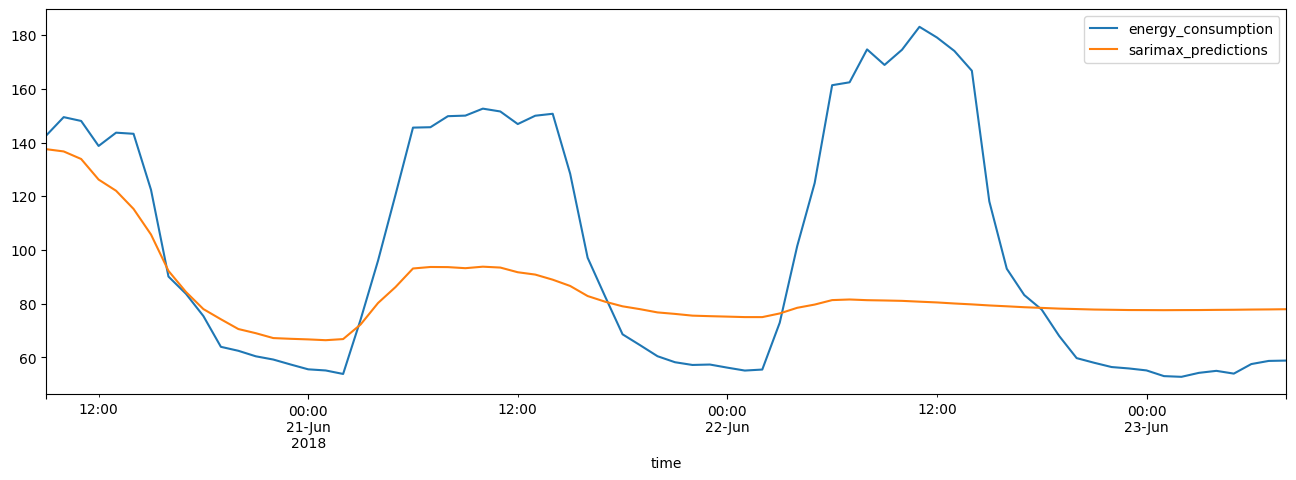

In [22]:
results_df = pd.DataFrame({'energy_consumption': test_data})
results_df['sarimax_predictions'] = predictions
results_df.plot(figsize = (16,5), legend=True)

Итак, мы видим, что метод SARIMAX способен с удовлетворительной точностью спрогнозировать суммарное потребление на ближайшие ~ 12 часов, но для реальной работы необходим горизонт прогнозирования хотя бы в сутки (а лучше -- двое).

Заметим, что прогноз на вторые сутки значительно меньше такового на первые. А на третьи не содержит характерного горба вовсе.

Попробуем спрогнозировать этим методом в ситуации, когда данные начинаются не с большого значения, а с малого.

In [23]:
data_size = 14000
check_data = df[col].values.astype('float16')[data_size - train_set_size : data_size]
stepwise_fit = auto_arima(check_data,
                          start_p=1,
                          start_q=1,
                          max_p=3,
                          max_q=3,
                          m=24,
                          start_P=0,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True,
                          n_jobs=4)
gc.collect()
print(stepwise_fit.summary())

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=14185.508, Time=11.36 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=21549.473, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=14335.742, Time=8.37 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=17839.853, Time=10.22 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=25579.490, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=14865.086, Time=2.73 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=35.82 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=13998.251, Time=48.07 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=84.31 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=17709.603, Time=31.44 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=14557.154, Time=28.29 sec
 ARIMA(2,0,1)(0,0,2)[24] intercept   : AIC=13576.762, Time=44.78 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=13712.572, Time=12.97 sec
 ARIMA(2,0,1)(1,0,2)[24] intercept   : AIC=inf, Time=94.56 sec
 ARIMA(2,0,1)

In [24]:
predictions = stepwise_fit.predict(n_periods=72)
test_data = df[col][data_size: data_size + len(predictions)]

mae = np.mean(np.abs(predictions - test_data))
mse = np.mean((predictions - test_data) ** 2)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 31.677874183119066
Mean Squared Error (MSE): 1476.715551310215
Root Mean Squared Error (RMSE): 38.42805682454182


<Axes: xlabel='time'>

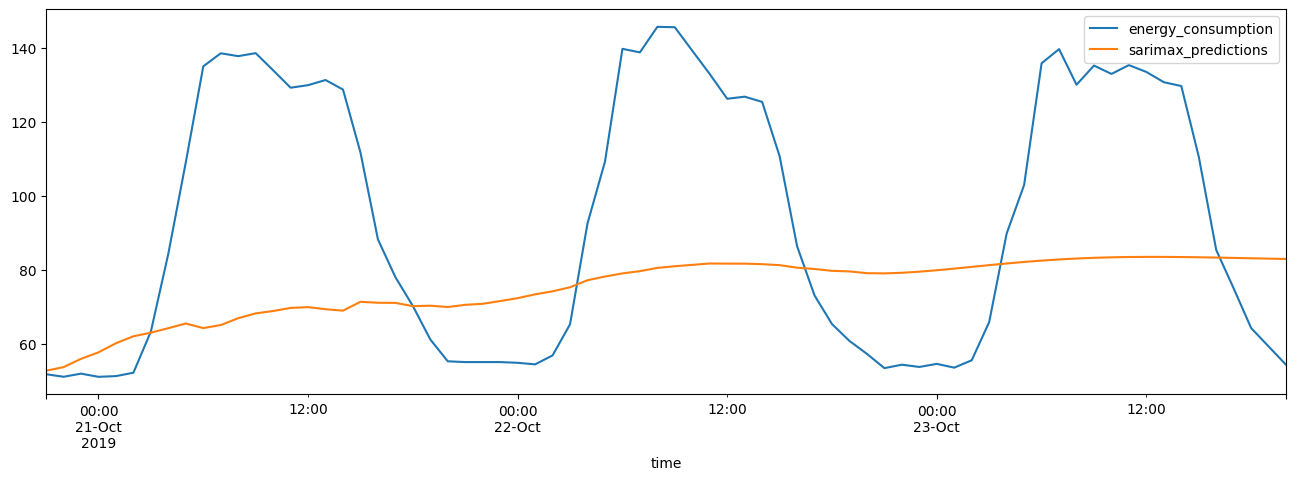

In [25]:
results_df = pd.DataFrame({'energy_consumption': test_data})
results_df['sarimax_predictions'] = predictions
results_df.plot(figsize = (16,5), legend=True)

Как мы видим, в данной точке метод SARIMAX, обученный на данных за последние 90 суток не даёт удовлетворительного прогноза.

# Алгоритм на основе метода решающих деревьев

В соответствии с [2] построим модель на основе библиотеки xgboost, в которой основным алгоритмом является метод решающих деревьев

In [26]:
def create_features(df, start, end, label=None):
    """
    Creates time series features from datetime index
    """
    dtfemp = df[start:end].copy()
    dtfemp['date'] = dtfemp.index
    dtfemp['hour'] = dtfemp['date'].dt.hour
    dtfemp['dayofweek'] = dtfemp['date'].dt.dayofweek
    dtfemp['quarter'] = dtfemp['date'].dt.quarter
    dtfemp['month'] = dtfemp['date'].dt.month
    dtfemp['year'] = dtfemp['date'].dt.year
    dtfemp['dayofyear'] = dtfemp['date'].dt.dayofyear
    dtfemp['dayofmonth'] = dtfemp['date'].dt.day
    dtfemp['weekofyear'] = dtfemp['date'].dt.weekofyear

    X = dtfemp[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = dtfemp[label]
        return X, y
    return X

train_data = df[data_size - train_set_size : data_size]
test_data = df[data_size: data_size + len(predictions)]

X_train, y_train = create_features(df, data_size - train_set_size, data_size, label=col)
X_test, y_test = create_features(df, data_size, data_size + len(predictions), label=col)

<ipython-input-26-e55b0640a8c0>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  dtfemp['weekofyear'] = dtfemp['date'].dt.weekofyear
<ipython-input-26-e55b0640a8c0>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  dtfemp['weekofyear'] = dtfemp['date'].dt.weekofyear


In [27]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

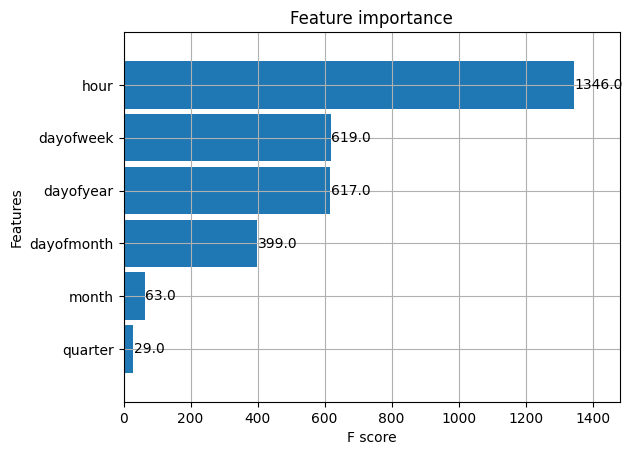

In [28]:
_ = plot_importance(reg, height=0.9)

In [29]:
predictions = reg.predict(X_test)
test_data = df[col][data_size: data_size + len(predictions)]

mae = np.mean(np.abs(predictions - test_data))
mse = np.mean((predictions - test_data) ** 2)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 2.409517136456944
Mean Squared Error (MSE): 9.888172424166905
Root Mean Squared Error (RMSE): 3.14454645762579


<Axes: xlabel='time'>

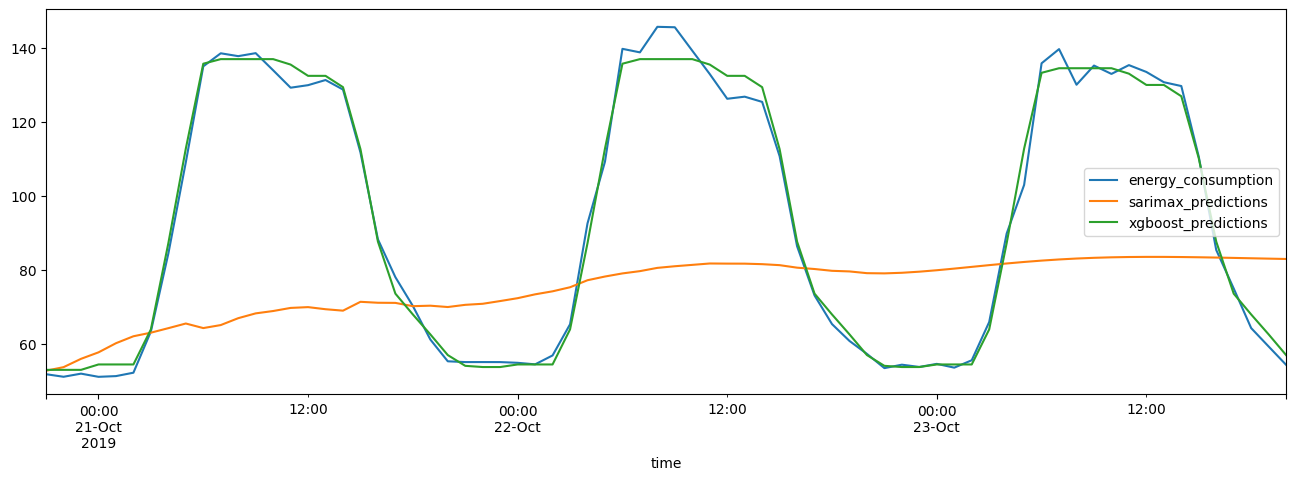

In [30]:
results_df['xgboost_predictions'] = predictions
results_df.plot(figsize = (16,5), legend=True)

Модель на основе метода решающих деревьев демонстрирует гораздо лучшие результаты, чем SARIMAX.

Построим схему алгоритма:

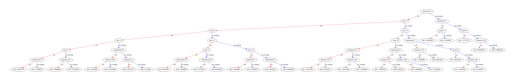

In [31]:
plot_tree(reg)

def plot_large_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    gvz = xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

plot_large_tree(reg, 'xgboost_energy_forecast.pdf')
plot_large_tree(reg, 'xgboost_energy_forecast_LR.pdf', 'LR')

# Алгоритмы на основе нейросетей (LSTM)

Попробуем построить модель на основе LSTM.

В качестве данных для обучения выберем такой же отрезок в 90 дней, находящийся в той же точке, где был предыдущий эксперимент.

Для наглядности будем отображать новые прогнозы на том же графике, что и последний эксперимент с ARIMA.

In [32]:
all_data = df[col][data_size - train_set_size : data_size].to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
all_data_normalized = scaler.fit_transform(all_data.reshape(-1, 1))

In [33]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [34]:
seq_length = 24
x, y = sliding_windows(all_data_normalized, seq_length)
print('x: ', x.shape, '; y: ', y.shape)


x:  (2135, 24, 1) ; y:  (2135, 1)


In [35]:
train_size = int(len(y) * 0.75)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

print("train shape is:", trainX.size())
print("train label shape is:", trainY.size())
print("test shape is:", testX.size())
print("test label shape is:", testY.size())

train shape is: torch.Size([1601, 24, 1])
train label shape is: torch.Size([1601, 1])
test shape is: torch.Size([534, 24, 1])
test label shape is: torch.Size([534, 1])


In [36]:
class SimplestDataset(torch.utils.data.Dataset):

  def __init__(self, X, Y):
    self.x_train = X
    self.y_train = Y

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.x_train[idx], self.y_train[idx]

train_data = SimplestDataset(trainX, trainY)
validation_data = SimplestDataset(testX, testY)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=2)


Создадим обертку для обучения и валидации модели.


In [37]:
class ModelTrainingWrapper(pl.LightningModule):
    def __init__(self, model_class, model_hparams, optimizer_class, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        self.optimizer_class=optimizer_class
        self.save_hyperparameters()
        self.model = model_class(**model_hparams)
        self.loss_module = nn.MSELoss()
        self.example_input_array = torch.zeros((1, 24, 1), dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), **self.hparams.optimizer_hparams)
        scheduler = ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, 'monitor': 'train_loss'}


    def shared_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_module(logits, y)
        return loss, logits


    def training_step(self, batch, batch_idx):
        _, labels = batch
        loss, predictions = self.shared_step(batch, batch_idx)
        self.log('train_loss', loss)
        mse = ((torch.pow((predictions - labels), 2)).sum()) / labels.size(0)
        self.log("train_mse", mse)
        return loss


    def validation_step(self, batch, batch_idx):
        _, labels = batch
        loss, predictions = self.shared_step(batch, batch_idx)
        self.log('val_loss', loss)
        mse = ((torch.pow((predictions - labels), 2)).sum()) / labels.size(0)
        self.log("val_mse", mse)
        return {'val_loss', loss}


    def test_step(self, batch, batch_idx):
        data, labels = batch
        preds = self.model(data)
        mse = ((torch.pow((preds - labels), 2)).sum()) / labels.size(0)
        self.log("test_mse", mse)


Основной метод для тренировки модели.

In [38]:
def train_model(model_class,
                train_loader,
                test_loader=train_loader,
                val_loader=val_loader,
                max_epochs=10,
                **kwargs):
    logger = TensorBoardLogger(save_dir=CHECKPOINT_PATH, name=model_class.__name__)
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),  # Where to save models
        devices=1,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
        logger=logger,
        log_every_n_steps=10,
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")

    model = ModelTrainingWrapper(model_class, **kwargs)
    trainer.fit(model, train_loader, test_loader)
    model = type(model).load_from_checkpoint(
        trainer.checkpoint_callback.best_model_path
    )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=True)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=True)
    result = {"test": test_result[0]["test_mse"], "val": val_result[0]["test_mse"]}

    return model, result

В соответствии с [4] построим минимальную LSTM-модель для оценки возможности предсказания с её помощью и отладки алгоритма

In [39]:
class LSTMProphet(nn.Module):
    def __init__(self, act_fn_class):
        """
        Inputs:
            act_fn - конструктор активации (nn.ReLU)
        """
        super().__init__()
        self.hparams = SimpleNamespace(
            act_fn_name=act_fn_class.__name__.lower(),
            act_fn=act_fn_class
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        self.dropout = nn.Dropout(p=0.2)

        self.lstm = nn.LSTM(input_size=24,
                            hidden_size=512,
                            num_layers=1,
                            batch_first=True,
                            dropout = 0.25)

        self.fc = nn.Linear(512, 1)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.transpose(1, 2)
        h_0 = Variable(torch.zeros(1, x.size(0), 512).to(device))

        c_0 = Variable(torch.zeros(1, x.size(0), 512).to(device))
        x_out, (h_out, _) = self.lstm(x, (h_0, c_0))
        x_out = x_out.view(-1, 512)
        out = self.fc(x_out)
        out = self.dropout(out)

        return out

In [40]:
start = time.perf_counter()
model, results = train_model(
    model_class=LSTMProphet,
    train_loader=train_loader,
    max_epochs=50,
    model_hparams={
        'act_fn_class': nn.ReLU
    },
    optimizer_class=optim.AdamW,
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-2},
)
print(results, 'за', time.perf_counter() - start, 'c')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type        | Params | In sizes   | Out sizes
---------------------------------------------------------------------
0 | model       | LSTMProphet | 1.1 M  | [1, 24, 1] | [1, 1]   
1 | loss_module | MSELoss     | 0      | ?          | ?        
-------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │   0.025655804201960564    │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │   0.027313746511936188    │
└───────────────────────────┴───────────────────────────┘

{'test': 0.027313746511936188, 'val': 0.025655804201960564} за 228.9454862130001 c


Добавим результаты прогнозирования на график для сравнения

<Axes: xlabel='time'>

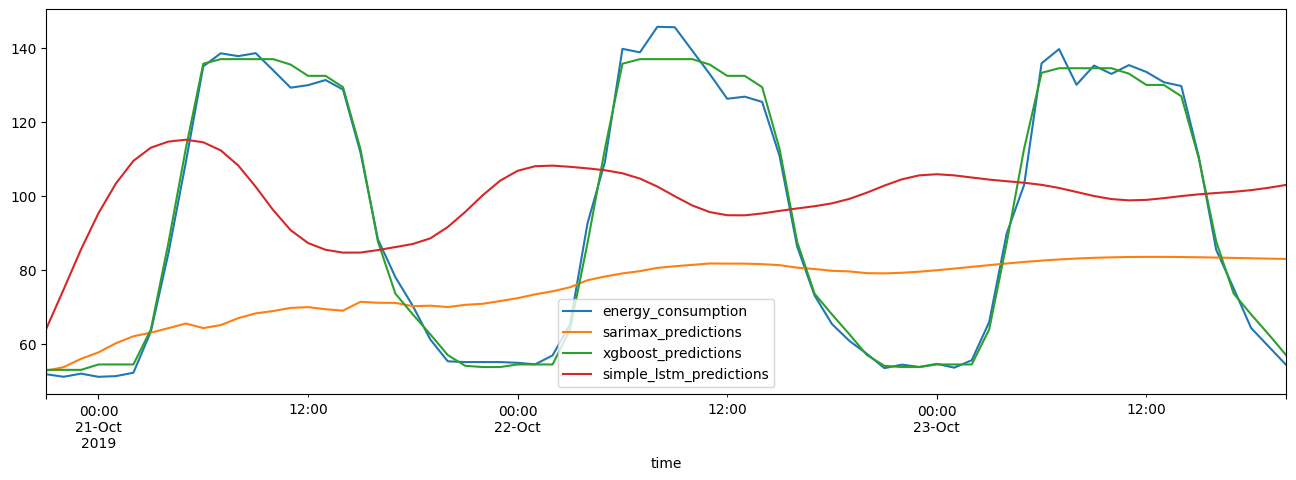

In [41]:
num_forecast_steps = 72
model.to(device)
model.eval()

sequence_to_plot = testX.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()
        unscaled = scaler.inverse_transform(predicted_value)
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(unscaled[0,0])

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

results_df['simple_lstm_predictions'] = forecasted_values
results_df.plot(figsize=(16, 5), legend=True)


Результаты лучше, чем классический алгоритм. Попробуем модель с бОльшим числом слоёв.

In [42]:
class LSTMProphetMulti(nn.Module):
    def __init__(self, act_fn_class):
        """
        Inputs:
            act_fn - конструктор активации (nn.ReLU)
        """
        super().__init__()
        self.hparams = SimpleNamespace(
            act_fn_name=act_fn_class.__name__.lower(),
            act_fn=act_fn_class
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        self.dropout = nn.Dropout(p=0.2)
        self.hidden_size = 512
        self.lstm = nn.LSTM(input_size=24,
                            hidden_size=self.hidden_size,
                            num_layers=4,
                            batch_first=True,
                            dropout = 0.25)

        self.fc = nn.Linear(512, 1)

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.transpose(1, 2)
        h_0 = Variable(torch.zeros(4, x.size(0), self.hidden_size).to(device))
        c_0 = Variable(torch.zeros(4, x.size(0), self.hidden_size).to(device))
        x_out, (h_out, cn) = self.lstm(x, (h_0, c_0))

        out = self.fc(x_out.view(-1, self.hidden_size))
        return out

In [43]:
start = time.perf_counter()
model, results = train_model(
    model_class=LSTMProphetMulti,
    train_loader=train_loader,
    max_epochs=100,
    model_hparams={
        'act_fn_class': nn.ReLU
    },
    optimizer_class=optim.AdamW,
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-2},
)
print(results, 'за', time.perf_counter() - start, 'c')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | In sizes   | Out sizes
--------------------------------------------------------------------------
0 | model       | LSTMProphetMulti | 7.4 M  | [1, 24, 1] | [1, 1]   
1 | loss_module | MSELoss          | 0      | ?          | ?        
--------------------------------------------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.624    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │   0.006299800239503384    │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mse          │    0.00642918236553669    │
└───────────────────────────┴───────────────────────────┘

{'test': 0.00642918236553669, 'val': 0.006299800239503384} за 1262.0572869940002 c


<Axes: xlabel='time'>

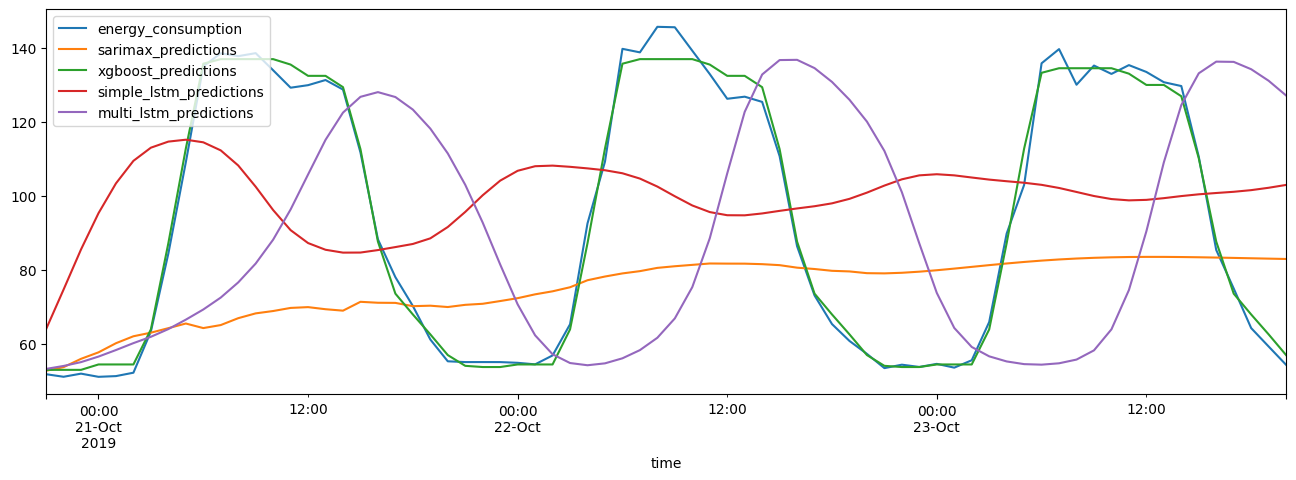

In [44]:
num_forecast_steps = 72
model.to(device)
model.eval()

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = testX.squeeze().cpu().numpy()
# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()
        unscaled = scaler.inverse_transform(predicted_value)
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(unscaled[0,0])

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

results_df['multi_lstm_predictions'] = forecasted_values
results_df.plot(figsize=(16, 5), legend=True)


Четырёхслойная LSTM-модель демонстрирует гораздо лучшие результаты, при этом укладываясь в 15 минут (при обучении на процессоре, то есть, при наличии видеокарты время переобучения модели будет ещё меньше),  что вполне приемлемо для почасового прогноза.

###  Динамика обучения LSTM-моделей.

Оранжевая линия --- обучение минимальной однослойной модели в течении 50 эпох. Синяя линия --- обучение четырёхслойной модели в течение 100 эпох.

val_loss_lstm.svg

Как мы видим, даже пятидесяти эпох может быть достаточно для выходя функции потерь на плато


# Заключение

Нами были рассмотрены алгоритмы прогнозирования временных рядов на примере электропотребления офисного здания: классические SARIMAX и на основе метода решающих деревьев, а также варианты LSTM: минимальный с одним слоем и более сложный, из четырёх слоёв.

Классический алгортим SARIMAX продемонстрировал наличие проблем на некоторых вариантах входных данных, кроме того, эксперименты с автоматическим подбором гиперпараметров показали, что разные данные приводят к разным наборам таковых, что означает необходимость регулярного переобучения модели для поддержания точности на должном уровне, что требует заметных вычислительных ресурсов.

Модели на основе нейросетей продемонстрировали гораздо более высокое качество прогноза по сравнению с классическими алгоритмами. Представляется, что таком модели вполне подходят для использования в реальных проектах.

Модель на основе метода решающих деревьев продемонстрировала лучшие результаты при минимальном времени обучения.

В качестве направлений для дальнейших исследований можно указать следующие:

1.   Дальнейшая оптимизация многослойной нейросети с целью определения минимального размера модели (как в плане количества LSTM-слоёв, так и в отрошении размеров скрытых слоёв и устройства классификационной головы), позволяющей получить приемлемое качество прогнозирования.
2.   Построение и большой модели и обучение её на максимально возможном наборе данных и последующей дистилляции результатов в меньшую модель, которую уже использовать в реальных приложениях. Данный путь, однако, хоть и позволяет получить лучшее качество прогнозирования, не подходит для использования в автономных системах. Впрочем, если предоставлять прогнозирование как услугу, то просматриваются некоторые перспективы.

# Библиография

1.   https://alkaline-ml.com/pmdarima/
2.   https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost
3.   https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/
4.   https://www.kaggle.com/code/drvaibhavkumar/lstm-for-time-series-prediction-in-pytorch
5.   https://www.kaggle.com/code/omershect/learning-pytorch-lstm-deep-learning-with-m5-data
